## 1. Import Libraries and Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multioutput import MultiOutputClassifier

In [4]:
dataset_scaled = pd.read_csv('DATASET.csv')

In [5]:
pleasant_weather = pd.read_csv('Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

In [7]:
print(dataset_scaled.dtypes.to_string())

DATE                             int64
MONTH                            int64
BASEL_cloud_cover              float64
BASEL_wind_speed               float64
BASEL_humidity                 float64
BASEL_pressure                 float64
BASEL_global_radiation         float64
BASEL_precipitation            float64
BASEL_snow_depth               float64
BASEL_sunshine                 float64
BASEL_temp_mean                float64
BASEL_temp_min                 float64
BASEL_temp_max                 float64
BELGRADE_cloud_cover           float64
BELGRADE_humidity              float64
BELGRADE_pressure              float64
BELGRADE_global_radiation      float64
BELGRADE_precipitation         float64
BELGRADE_sunshine              float64
BELGRADE_temp_mean             float64
BELGRADE_temp_min              float64
BELGRADE_temp_max              float64
BUDAPEST_cloud_cover           float64
BUDAPEST_humidity              float64
BUDAPEST_pressure              float64
BUDAPEST_global_radiation

In [8]:
print(pleasant_weather.dtypes.to_string())

DATE                           int64
BASEL_pleasant_weather         int64
BELGRADE_pleasant_weather      int64
BUDAPEST_pleasant_weather      int64
DEBILT_pleasant_weather        int64
DUSSELDORF_pleasant_weather    int64
HEATHROW_pleasant_weather      int64
KASSEL_pleasant_weather        int64
LJUBLJANA_pleasant_weather     int64
MAASTRICHT_pleasant_weather    int64
MADRID_pleasant_weather        int64
MUNCHENB_pleasant_weather      int64
OSLO_pleasant_weather          int64
SONNBLICK_pleasant_weather     int64
STOCKHOLM_pleasant_weather     int64
VALENTIA_pleasant_weather      int64


### Curate temperature related variables (and exclude Gdasnk, Roma, Tours)

In [10]:
### List comprehension to filter columns
columns_to_keep = [
    col for col in dataset_scaled.columns
    if 'temp_' in col
    and not any(city in col for city in ['ROMA', 'TOURS', 'GDANSK'])
]

# Create the new DataFrame
df_temp = dataset_scaled[columns_to_keep]


## 2. Prepare Training Dataset

In [11]:
### Create an 'X' matrix; drop unneeded columns
X = df_temp
y = pleasant_weather.drop(['DATE'], axis=1)

In [12]:
### Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
y_train.head()

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
8196,0,1,1,1,1,0,1,0,1,1,1,0,0,0,0
20472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


✅ Why MultiOutputClassifier Is Needed
You're predicting 15 separate yes/no values at once — one for each station.
That’s a textbook multi-label classification task.

In [20]:
print(X_train.shape)
print(y_train.shape)

(17212, 45)
(17212, 15)


In [22]:
X_train.columns

Index(['BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max',
       'BELGRADE_temp_mean', 'BELGRADE_temp_min', 'BELGRADE_temp_max',
       'BUDAPEST_temp_mean', 'BUDAPEST_temp_min', 'BUDAPEST_temp_max',
       'DEBILT_temp_mean', 'DEBILT_temp_min', 'DEBILT_temp_max',
       'DUSSELDORF_temp_mean', 'DUSSELDORF_temp_min', 'DUSSELDORF_temp_max',
       'HEATHROW_temp_mean', 'HEATHROW_temp_min', 'HEATHROW_temp_max',
       'KASSEL_temp_mean', 'KASSEL_temp_min', 'KASSEL_temp_max',
       'LJUBLJANA_temp_mean', 'LJUBLJANA_temp_min', 'LJUBLJANA_temp_max',
       'MAASTRICHT_temp_mean', 'MAASTRICHT_temp_min', 'MAASTRICHT_temp_max',
       'MADRID_temp_mean', 'MADRID_temp_min', 'MADRID_temp_max',
       'MUNCHENB_temp_mean', 'MUNCHENB_temp_min', 'MUNCHENB_temp_max',
       'OSLO_temp_mean', 'OSLO_temp_min', 'OSLO_temp_max',
       'SONNBLICK_temp_mean', 'SONNBLICK_temp_min', 'SONNBLICK_temp_max',
       'STOCKHOLM_temp_mean', 'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max',
       'VALENTIA_temp_me

## 3. K-Nearest Neighbors Model

### 🧐 Recap: What Are We Even Doing?
- You have X: 45 temperature-based features (mean, min, max × 15 stations)
- You have y: 15 boolean labels (1/0 pleasantness for those same stations)
- Each row = 1 date
- You're using KNN to predict each station’s pleasantness on a new day, based on weather across all stations.

In [13]:
#Run the model with neighbors equal to 1 to 4, test the accuracy
k_range = np.arange(1,4)
train_acc = np.empty(len(k_range))
test_acc = np.empty(len(k_range))
scores = {}
scores_list = []
for i, k in enumerate(k_range):
    print("i -", i)
    print("k -", k_range)
    knn = KNeighborsClassifier(n_neighbors=k)
    classifier = MultiOutputClassifier(knn, n_jobs=-1) #ADD THIS LINE
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_acc[i] = knn.score(X_train, np.array(y_train)) #CHANGE THIS LINE
    test_acc[i] = knn.score(X_test, np.array(y_test)) #CHANGE THIS LINE

i - 0
k - [1 2 3]
i - 1
k - [1 2 3]
i - 2
k - [1 2 3]


<function matplotlib.pyplot.show(close=None, block=None)>

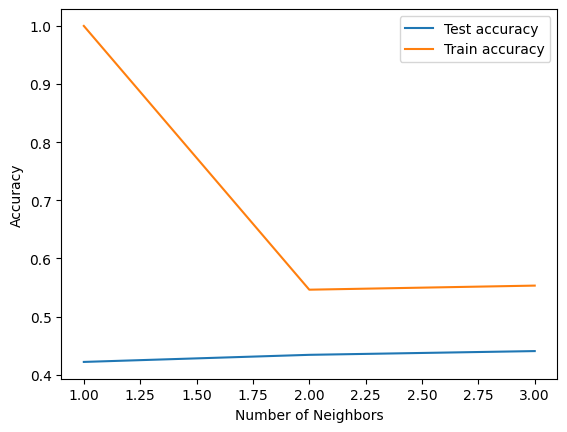

In [14]:
### plot the relationship between number of neighbors and accuracy
plt.plot(k_range, test_acc, label = 'Test accuracy')
plt.plot(k_range, train_acc, label = 'Train accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show

#### ⚠️ Reminder Caveat from CareerFoundry lesson text:

"KNN models is that they **don’t work very well on data with multiple dimensions**, for instance, 3D data with X, Y, and Z components (think spatial dimensions or coordinates for delivery that include moving upward). This is because measuring the distances between points (to find similarities) becomes prohibitive in a larger dimensional space. For this reason, you’ll most often only be working with two dimensions when using KNN models."

#### Observations:

🧪 1. Training Accuracy = 1.0 for k=1
- KNN with k=1 memorizes the training data.
- Every point is its own nearest neighbor → accuracy = 100%
- Overfitting central. 🚨

🪦 2. Train Accuracy Drops, Test Accuracy Stays Low
- As k increases, the model relies more on neighborhoods instead of individual points.
- Test accuracy stays near 0.4, meaning it’s not learning much at all that generalizes to unseen data.

#### Why Might This Be Happening?
Too Many Output Labels



## 4. Confusion Matrices

In [23]:
print(train_acc[2])
print(test_acc[2])


0.5532186846386242
0.44057162774485886


#### Starting Parameters:
- Number of neighbors tested: 1–3
- Model: KNeighborsClassifier wrapped in MultiOutputClassifier
- Train/test split: scikit default (75/25)
- Feature Scaled: temperature metrics

#### Final Parameters
- Final number of neighbors: 3
- Final model: KNeighborsClassifier(n_neighbors=3) wrapped in MultiOutputClassifier

#### Accuracy
- training data: 0.55
- test data: 0.44

#### Notes:
- Increasing the number of neighbors slightly improved test accuracy and prevented overfitting (train accuracy dropped from 1.0 to 0.55).
- However, accuracy across all 15 outputs remained low, suggesting poor generalization or weak signal in features.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


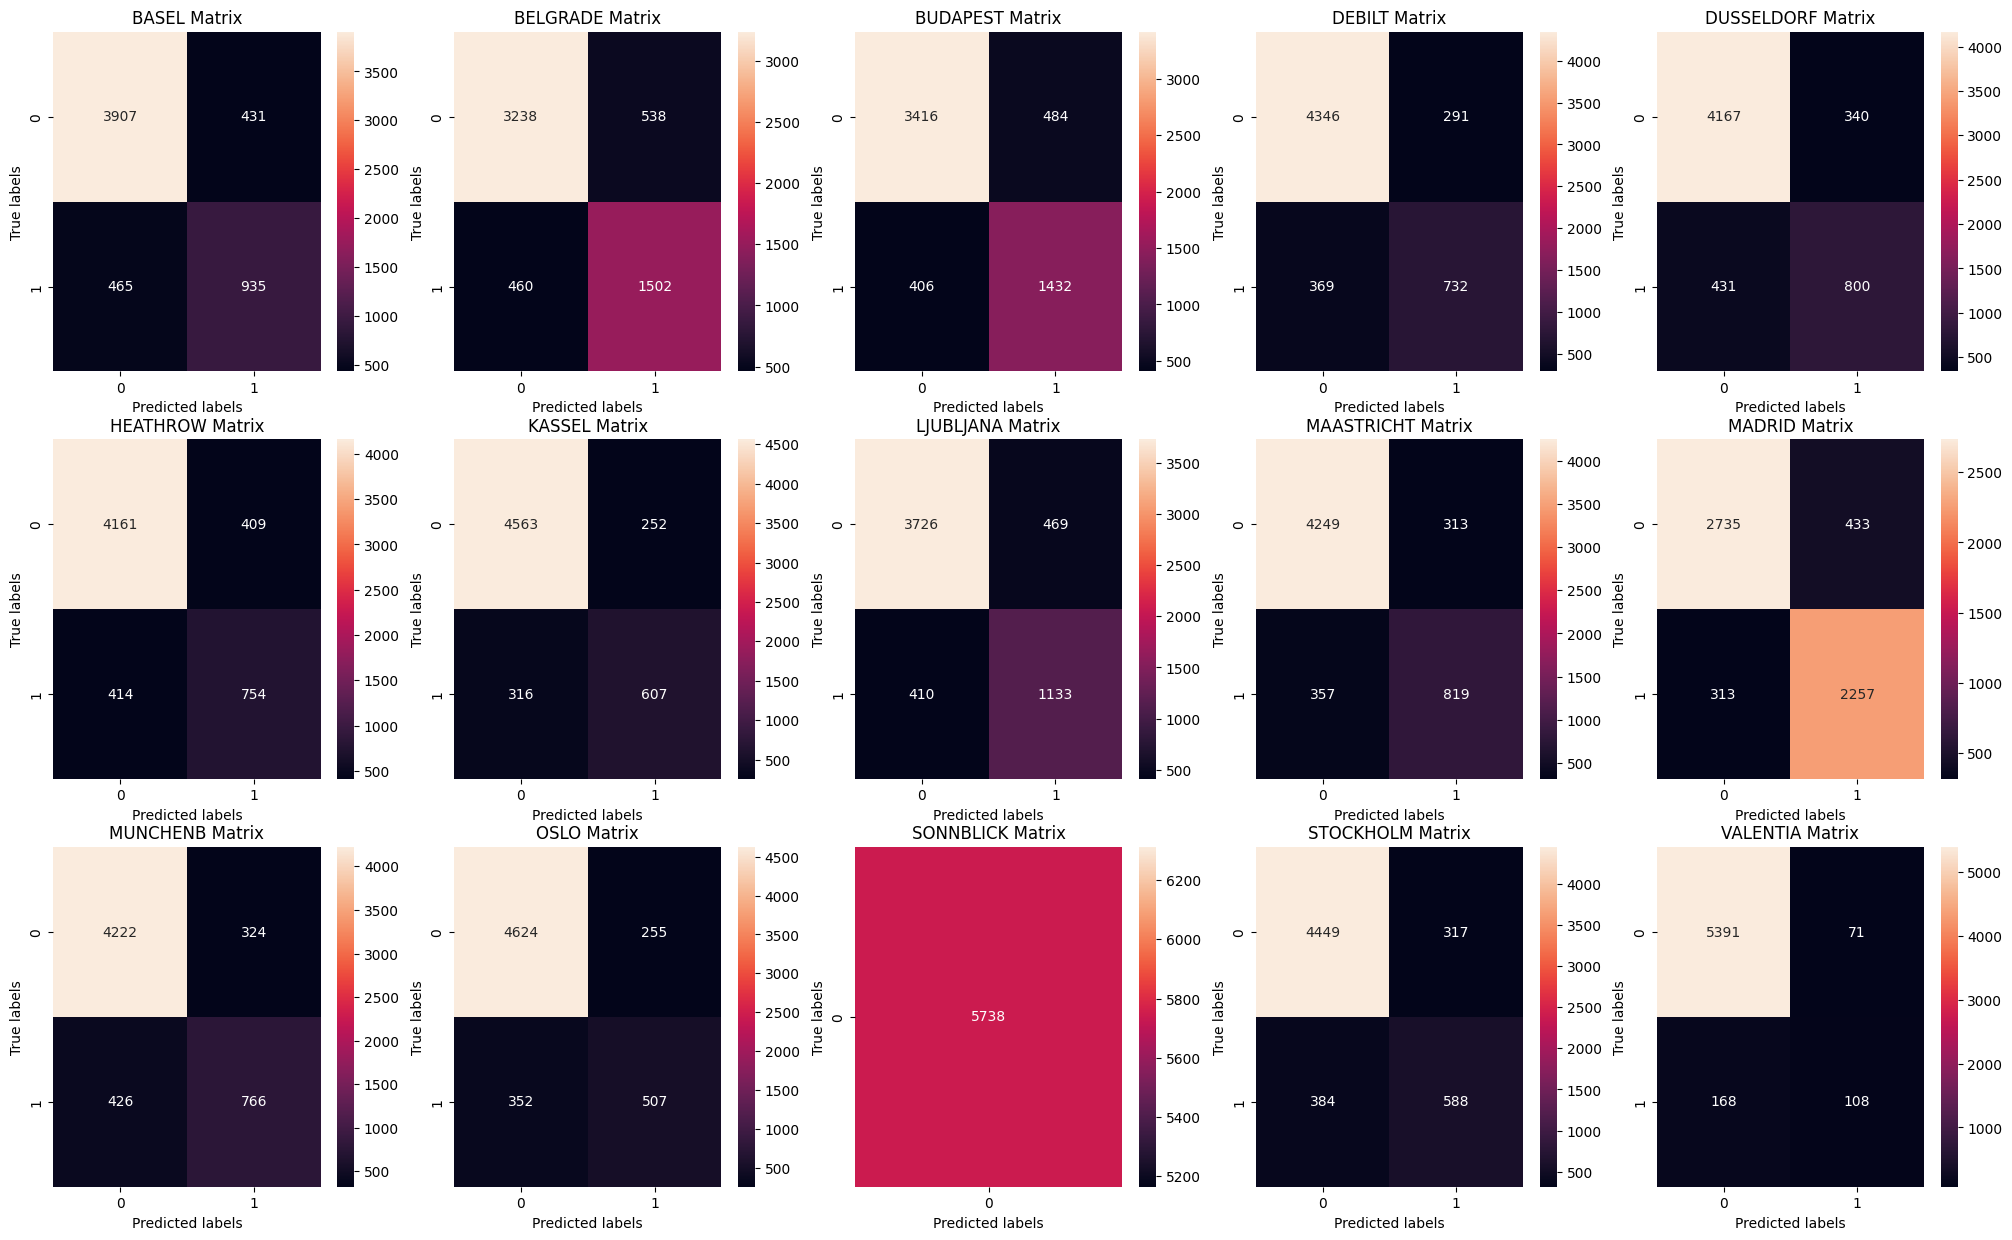

In [16]:
locations = list({x.split("_")[0] for x in df_temp.columns if x not in ["MONTH", "DATE"]})
locations.sort()
locations
key = "_pleasant_weather"
stations = []
figure, ax = plt.subplots(3, 5, figsize=(25,15))
labels = ['pleasant', 'unpleasant']
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        cm = confusion_matrix(y_test.loc[:,name+key], y_pred[:,count])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels');
        ax[i,j].set_title(name +' Matrix');
        #ax[i,j].xaxis.set_ticklabels(labels); #These two lines may throw an error depending on SONNBLICK data. Can you tell why?
        #ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

- True 0, Predicted 0 (Top Left, a): Correctly predicted negatives (True Negatives)

- True 0, Predicted 1 (Top Right, b): Incorrectly predicted positives (False Positives)

- True 1, Predicted 0 (Bottom Left, c): Incorrectly predicted negatives (False Negatives)

- True 1, Predicted 1 (Bottom Right, d): Correctly predicted positives (True Positives)

### Conclusions:
It appears the model consistently performs better at identifying unpleasant days than pleasant ones. Across all stations, there are notable counts of both false positives and false negatives — no weather station achieves high accuracy. SONNBLICK stands out as potentially problematic, predicting only a single class, which suggests either data quality issues or extreme class imbalance. While overfitting may be a concern, especially given the steep drop in accuracy between 1 and 2 neighbors, the final model used k = 3, which already showed signs of degraded performance. The unreliable predictions from SONNBLICK likely skew the overall accuracy and may be masking the true behavior of the model on more balanced stations.